# Imports and data

I have tried a series of non-neural network models (ignoring Doc2Vec) to classify the rotten vs. fresh Rotten Tomatoes review scores, based on the review text. I skipped building neural networks from scratch, or using pre-trained neural networks due to time constraints, but I could build them if desired. The results aren't necessarily amazing (about 3% over baseline), improving from ~63% (if we predict every row as fresh) to 66% (our VADER + RF model).

Notes: I just used the test set instead of the validation set in these cases. Best practices would be to use the validation set directly in the model where possible (e.g. neural nets), or as a "test" set during the hyperparameter tuning and model building phase. The actual test set should only be used when a few models have been optimized for a final comparison and sanity check with data that the models have not seen.

I also did not write this code to be wrapped in functions / classes, but I would do that in case of a project that would actually be productionized. It tends to add significant time to a project.

In [1]:
# We will use the VADER Sentiment analysis tool (also available in NLTK library)
!pip install vaderSentiment

     |████████████████████████████████| 125 kB 8.0 MB/s 


In [40]:
import pandas as pd
import numpy as np
import time
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


# Check out data

In [4]:
df = pd.read_csv('/content/drive/My Drive/rotten_tomatoes_critic_reviews.csv')

In [5]:
df.shape

(1130017, 8)

In [6]:
df.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


## Isolate meaningful columns and drop nulls

In [7]:
df = df[['review_content', 'review_type']]

In [8]:
df.isna().mean()

review_content    0.058235
review_type       0.000000
dtype: float64

In [9]:
df = df.dropna(subset = ['review_content'])

In [10]:
df.head()

,review_content,review_type
0,A fantasy adventure that fuses Greek mythology...,Fresh
1,"Uma Thurman as Medusa, the gorgon with a coiff...",Fresh
2,With a top-notch cast and dazzling special eff...,Fresh
3,Whether audiences will get behind The Lightnin...,Fresh
4,What's really lacking in The Lightning Thief i...,Rotten


## Map Fresh to 1 and Rotten to 0 to make machine readable y variable

In [11]:
df['review_type'] = df['review_type'].map({'Fresh' : 1, 'Rotten' : 0})

# Split into training / test / val sets

In [13]:
# create training, test, val sets - I'm using an 80/10/10 split, since we have a lot of data

In [12]:
X = df['review_content']
y = df['review_type']

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, random_state = 78, test_size = .2)

In [14]:
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, stratify = y_val, random_state = 78, test_size = .5)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((851368,), (851368,), (106421,), (106421,), (106422,), (106422,))

## Classify using VADER (sentiment analysis)

In [16]:
vader_labeler = SentimentIntensityAnalyzer()

In [17]:
time_start = time.time()

X_train_df = X_train.map(lambda x: vader_labeler.polarity_scores(x))

print(time.time() - time_start)

156.05316638946533


In [18]:
X_train_df

660191     {'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'comp...
183820     {'neg': 0.361, 'neu': 0.506, 'pos': 0.133, 'co...
1124842    {'neg': 0.0, 'neu': 0.759, 'pos': 0.241, 'comp...
626445     {'neg': 0.072, 'neu': 0.649, 'pos': 0.279, 'co...
504896     {'neg': 0.128, 'neu': 0.872, 'pos': 0.0, 'comp...
                                 ...                        
258256     {'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'comp...
568404     {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
119280     {'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compou...
771983     {'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'comp...
768839     {'neg': 0.143, 'neu': 0.265, 'pos': 0.593, 'co...
Name: review_content, Length: 851368, dtype: object

In [19]:
X_train_df = pd.DataFrame(X_train_df.values.tolist(), index = X_train_df.index)

In [20]:
X_train_df.head()

,neg,neu,pos,compound
660191,0.213,0.787,0.000,-0.5574
183820,0.361,0.506,0.133,-0.5574
1124842,0.000,0.759,0.241,0.7906
626445,0.072,0.649,0.279,0.8225
504896,0.128,0.872,0.000,-0.2960


In [21]:
X_train[0:10]

660191     A Reagan-era screed against affirmative action...
183820     Full of rude energy and a very appealing degre...
1124842    Einstein has a handsome period look, even when...
626445     If you've already seen Deadpool 2 at full stre...
504896     What's missing here is Mr. Kelley's stock in t...
843597                      It's impossible not to be moved.
408717     Music is so central to Hearts Beat Loud that i...
199774     Born To Dance isn't original, but it's still w...
462750     Snappy dialogue throughout that's fun to keep ...
347466     As director, Angelina Jolie brings to life all...
Name: review_content, dtype: object

### Check Score correlation

In [22]:
X_train_df_check = X_train_df.copy()

In [23]:
X_train_df_check['score'] = y_train

In [24]:
X_train_df_check.corr()

,neg,neu,pos,compound,score
neg,1.000000,-0.472226,-0.258440,-0.678932,-0.196750
neu,-0.472226,1.000000,-0.729487,-0.166967,-0.095301
pos,-0.258440,-0.729487,1.000000,0.709807,0.257110
compound,-0.678932,-0.166967,0.709807,1.000000,0.283187
score,-0.196750,-0.095301,0.257110,0.283187,1.000000


### Random Forest Classifier

In [27]:
rf = RandomForestClassifier(random_state=20)

In [28]:
rf.fit(X_train_df, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=20, verbose=0,
                       warm_start=False)

In [29]:
rf.score(X_train_df, y_train)

0.8124136683549299

In [30]:
time_start = time.time()

X_test_df = X_test.map(lambda x: vader_labeler.polarity_scores(x))

print(time.time() - time_start)

19.515776872634888


In [31]:
X_test_df = pd.DataFrame(X_test_df.values.tolist(), index = X_test_df.index)

In [32]:
rf.score(X_test_df, y_test)

0.6697832194773587

In [33]:
y_test.value_counts()

1    68104
0    38317
Name: review_type, dtype: int64

In [34]:
### THIS IS ONE TYPE OF BASELINE MODEL (Assigning all values to the majority class).
# Our model here with a 66.9% accuracy has improved on the vaseline by about 3%

y_test.value_counts(normalize = True)

1    0.639949
0    0.360051
Name: review_type, dtype: float64

#### Quick confusion matrix to check results

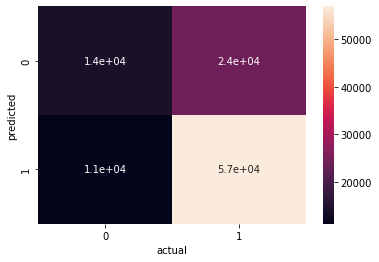

In [42]:
sns.heatmap(confusion_matrix(y_test, rf.predict(X_test_df)), annot = True)
plt.ylabel('predicted')
plt.xlabel('actual');

In [ ]:
# The model has more false negatives, than false positives, which may be a 
# slight surprise given the skew toward positive records. The random forest
# threshold could be adjusted along the ROC/AUC to shift these predictions 

#### Save model for app (don't need to rerun this)

In [45]:
# rf_model_small = RandomForestClassifier(n_estimators = 100, max_depth = 5, n_jobs = -2)

In [46]:
# rf_model_small.fit(X_train_df, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-2, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [47]:
# rf_model_small.score(X_test_df, y_test)

0.6651694684319824

In [44]:
# save the model to disk
#filename = '/content/drive/My Drive/movie_review_small_rf_model.sav'
#pickle.dump(rf, open(filename, 'wb'))

In [ ]:
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

### Random Forest Classifier with RandomizedSearchCV

In [75]:
# Just to show a quick example of hyperparameter tuning - it is unlikely to achieve much improvement, and it will take a long time to run.
# This would probably work better with logistic regression hyperparameter tuning

In [54]:
distributions = {"n_estimators" : [int(x) for x in np.linspace(100, 1000, 101)],
                 "max_depth" : [int(x) for x in np.linspace(1,10,10)],
                 "min_samples_leaf" : [int(x) for x in np.linspace(1,10,10)],
                 "class_weight" : ['balanced', 'balanced_subsample']}

In [55]:
np.linspace(100, 1000, 101)[0].dtype

dtype('float64')

In [56]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [57]:
rf_rand_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions = distributions, n_jobs = -2, cv = 5, random_state = 42)

In [58]:
rf_rand_search.fit(X_train_df, y_train)

KeyboardInterrupt: ignored

## Logistic Regression Classifier

In [52]:
logreg_mod = LogisticRegressionCV()

In [53]:
logreg_mod.fit(X_train_df, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [54]:
logreg_mod.score(X_train_df, y_train)

0.6637540992849156

In [56]:
# Vanilla logistic regression is only slightly worse than Random Forest
# Could potentially be better with hyperparameter tuning. I could do a
# randomized search here as well, but will skip for now for time efficiency

logreg_mod.score(X_test_df, y_test)

0.6646620497834074

## Naive Bayes Classifier

In [71]:
# I was just curious if a default Naive Bayes Classifier would do better than
# Random Forest or baseline. Unsurprisingly performs worse than RF with default params

nb_model = GaussianNB()

In [72]:
nb_model.fit(X_train_df, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [73]:
nb_model.score(X_train_df, y_train)

0.6431637082906569

In [74]:
nb_model.score(X_test_df, y_test)

0.6414993281401227

# Classify using Doc2Vec

In [ ]:
# Trying out Doc2Vec to build features - this is unlikely to work well, but worth a shot

In [58]:
# create document corpus

documents = [TaggedDocument(item[0], [item[1]]) for item in zip(X_train.values, X_train.index)]

In [67]:
# Initialize doc2vec model

model = Doc2Vec(documents, vector_size=500, window=2, min_count=1, workers=4)

In [75]:
# Assign vectors from model to training set

X_train_docvecs = [model.infer_vector(item) for item in X_train]

In [ ]:
X_train_docvecs[0:5]

## Doc2Vec Random Forest Model

In [76]:
rf_doc2vec = RandomForestClassifier()

In [77]:
rf_doc2vec.fit(X_train_docvecs, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [78]:
X_test_docvecs = [model.infer_vector(item) for item in X_test]

In [79]:
rf_doc2vec.score(X_test_docvecs, y_test)

0.636603677845538

In [ ]:
# Doc2Vec was no better than baseline, and worse than VADER scores

# Bag of Words models

In [ ]:
# We can try bag of words (CountVectorizer), or normalized bag of words representations for the models as well (e.g. TFIDF).
# These would produce sparse matrices to run other ML models on.
# I am happy to show that I can do this if you would like (and it MIGHT give better results).

# Summary

I have shown (or explained) a few ways to represent the reviews numerically and how to run some models on those numeric representations. This is just what I could accomplish in a few hours, and didn't get an outstanding model yet, but should be able to improve it over time. One very likely way to improve the VADER model would be to separate movies by genre if possible. I haven't checked yet, but I have a feeling that Horror movies would often be incorrectly classified as Rotten because they may have "negative" connotation words according to VADER such as "scary, horrible, terrifying, etc." Breaking down the training into several models by genre (or adding a genre variable) may be valuable. Happy to discuss further!

Note: There are many other models that could be used, but it is almost certain that a better pre-processing / numerical representation of the data would improve results better. Additional feature engineering (such as adding genre), would also likely improve results far more than using other models. It WOULD be worth trying some neural network models, however.